## Train sign classifier network (backbone)

In [1]:
#%env CUDA_LAUNCH_BLOCKING=1

In [2]:
import os.path
import numpy as np
from PIL import Image
# torch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
# addons
import torchvision
from torchvision import transforms as trafos

In [3]:
#%matplotlib inline
import matplotlib.pyplot as plt

/home/tobias/.virtualenvs/pytorch/local/lib/python2.7/site-packages/matplotlib/__init__.py:907: MatplotlibDeprecationWarning: The backend.qt4 rcParam was deprecated in version 2.2.  In order to force the use of a specific Qt binding, either import that binding first, or set the QT_API environment variable.
  mplDeprecation)


In [4]:
relative_path = '../../'
# ensure that parent path is on the python path in order to have all packages available
import sys, os
parent_path = os.path.join(os.getcwd(), relative_path)
parent_path = os.path.realpath(parent_path)  # os.path.abspath(...)
sys.path.insert(0, parent_path)

In [5]:
# mystuff
from lib.utils.pytorch_utils import train_model, get_tensorboard_writer, prepare_embedding, visualize_model                          
from lib.utils.transform_utils import UnNormalize
from lib.datasets.cunei_dataset import CuneiformCollection
from lib.models.mobilenetv2_mod03 import MobileNetV2

In [6]:
from tqdm import tqdm
import time
hh = 0.001
## time.sleep(60*60*hh)
for i in tqdm(range(int(6*60*hh))):
    time.sleep(10)

0it [00:00, ?it/s]


### Config Basics

In [7]:
model_version = 'v001'

# config datasets for training and testing
train_data_set = 'train_C'
test_data_set = 'test_full'

# config backbone architecture
width_mult = 0.625
arch_opt = 1

# config schedule
#num_epochs = 61  
num_epochs = 111

#lr_milestones = [20, 40]
#lr_milestones = [25, 50]
lr_milestones = [50, 100]

In [8]:
# config generated data
with_gen_data = True

gen_data_version = 'v001_hp04'  # version to use
    
gen_folder = 'results_ssd/{}/'.format(gen_data_version)

#gen_collections = ['train']
gen_collections = ['saa01', 'saa05', 'saa08', 'saa10', 'saa13', 'saa16']

In [9]:
# config data preprocess and augmentation
params = dict(batch_size=[128, 16],
              context_pad=10,
              min_align_ratio=0.3,
              crop_size=[224, 224],
              patch_size=[246, 246],
              img_channels=1,
              num_workers=4, # 0 single thread
              num_classes=240,
              gray_mean=[0.5],
              gray_std=[1.0],
             )
if with_gen_data:
    params.update(gen_folder=gen_folder, 
                  gen_collections=gen_collections)

In [10]:
# set log file name
if with_gen_data:
    version_remark = '{}_mobilenetv2_224_gen_{}'
    version_remark = version_remark.format(train_data_set, gen_data_version)
else:
    version_remark = '{}_mobilenetv2_224'
    version_remark = version_remark.format(train_data_set)

### Config Data Augmentation

In [11]:
num_classes = params['num_classes']
crop_h, crop_w = params['crop_size']
full_h, full_w = params['patch_size']
context_pad = params['context_pad']
num_c = params['img_channels']
gray_mean = params['gray_mean']
gray_std = params['gray_std']

In [12]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': trafos.Compose([
        trafos.Lambda(lambda x: x.convert('L')), # comment, if num_c = 3        
        trafos.Resize((full_h, full_w), interpolation=Image.BILINEAR),
        trafos.RandomCrop((full_h - 8, full_w - 8)),
        trafos.RandomRotation(8, resample=Image.BILINEAR, expand=False),
        trafos.CenterCrop((crop_h + 12, crop_w + 12)),
        
        trafos.RandomResizedCrop(crop_h, scale=(0.8,1.0), ratio=(3./4., 4./3.), interpolation=Image.BILINEAR),
        trafos.ColorJitter(0.3,0.3,0,0),
        trafos.ToTensor(),
        trafos.Normalize(mean=gray_mean * num_c, std=gray_std * num_c),
    ]),
    'dev': trafos.Compose([
        trafos.Lambda(lambda x: x.convert('L')), # comment, if num_c = 3
        trafos.Resize((crop_h, crop_w), interpolation=Image.BILINEAR),
        trafos.ToTensor(),
        trafos.Normalize(mean=gray_mean * num_c, std=gray_std * num_c),
    ]),
}

In [13]:
re_transform = trafos.Compose([
    UnNormalize(mean=gray_mean, std=gray_std),
    trafos.ToPILImage(),
                                              ])
re_transform_rgb = trafos.Compose([
    UnNormalize(mean=gray_mean * 3, std=gray_std * 3),
    trafos.ToPILImage(),
                                              ])

### Create Datasets and Loaders

In [14]:
# Datasets
image_datasets = {x[0]: CuneiformCollection(params, transform=data_transforms[x[0]], 
                    target_transform=None, relative_path=relative_path, split=x[1])
                  for x in [['train', train_data_set], ['dev', test_data_set]]}
# Data Loaders
num_workers = [params['num_workers'], 0]
batch_size = params['batch_size']
shuffle_set = [True, False]
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size[i], shuffle=shuffle_set[i], 
                                              num_workers=num_workers[i], pin_memory=False, drop_last=True)
              for i, x in enumerate(['train', 'dev'])}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'dev']}

class sample count stats: 
count     204.000000
mean      501.735294
std       928.851714
min         1.000000
25%        49.250000
50%       155.000000
75%       549.500000
max      7878.000000
Name: train_label, dtype: float64
Drop 0 outlier samples!


  0%|          | 0/34 [00:00<?, ?it/s]

Setup train_C dataset spanning ['train_C', 'ransac', 'saa01', 'saa05', 'saa08', 'saa10', 'saa13', 'saa16'] collections.
Select 103099 bboxes from 1681 tablets.
Drop 108 outlier samples!


100%|██████████| 34/34 [00:03<00:00, 10.63it/s]

Setup test_full dataset spanning ['test_full'] collections.
Select 3466 bboxes from 34 tablets.


### Visualize Trainset Samples

In [15]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))
print(inputs.shape, classes.shape, inputs.min(), inputs.max())

(torch.Size([128, 1, 224, 224]), torch.Size([128]), tensor(-0.5000), tensor(0.5000))


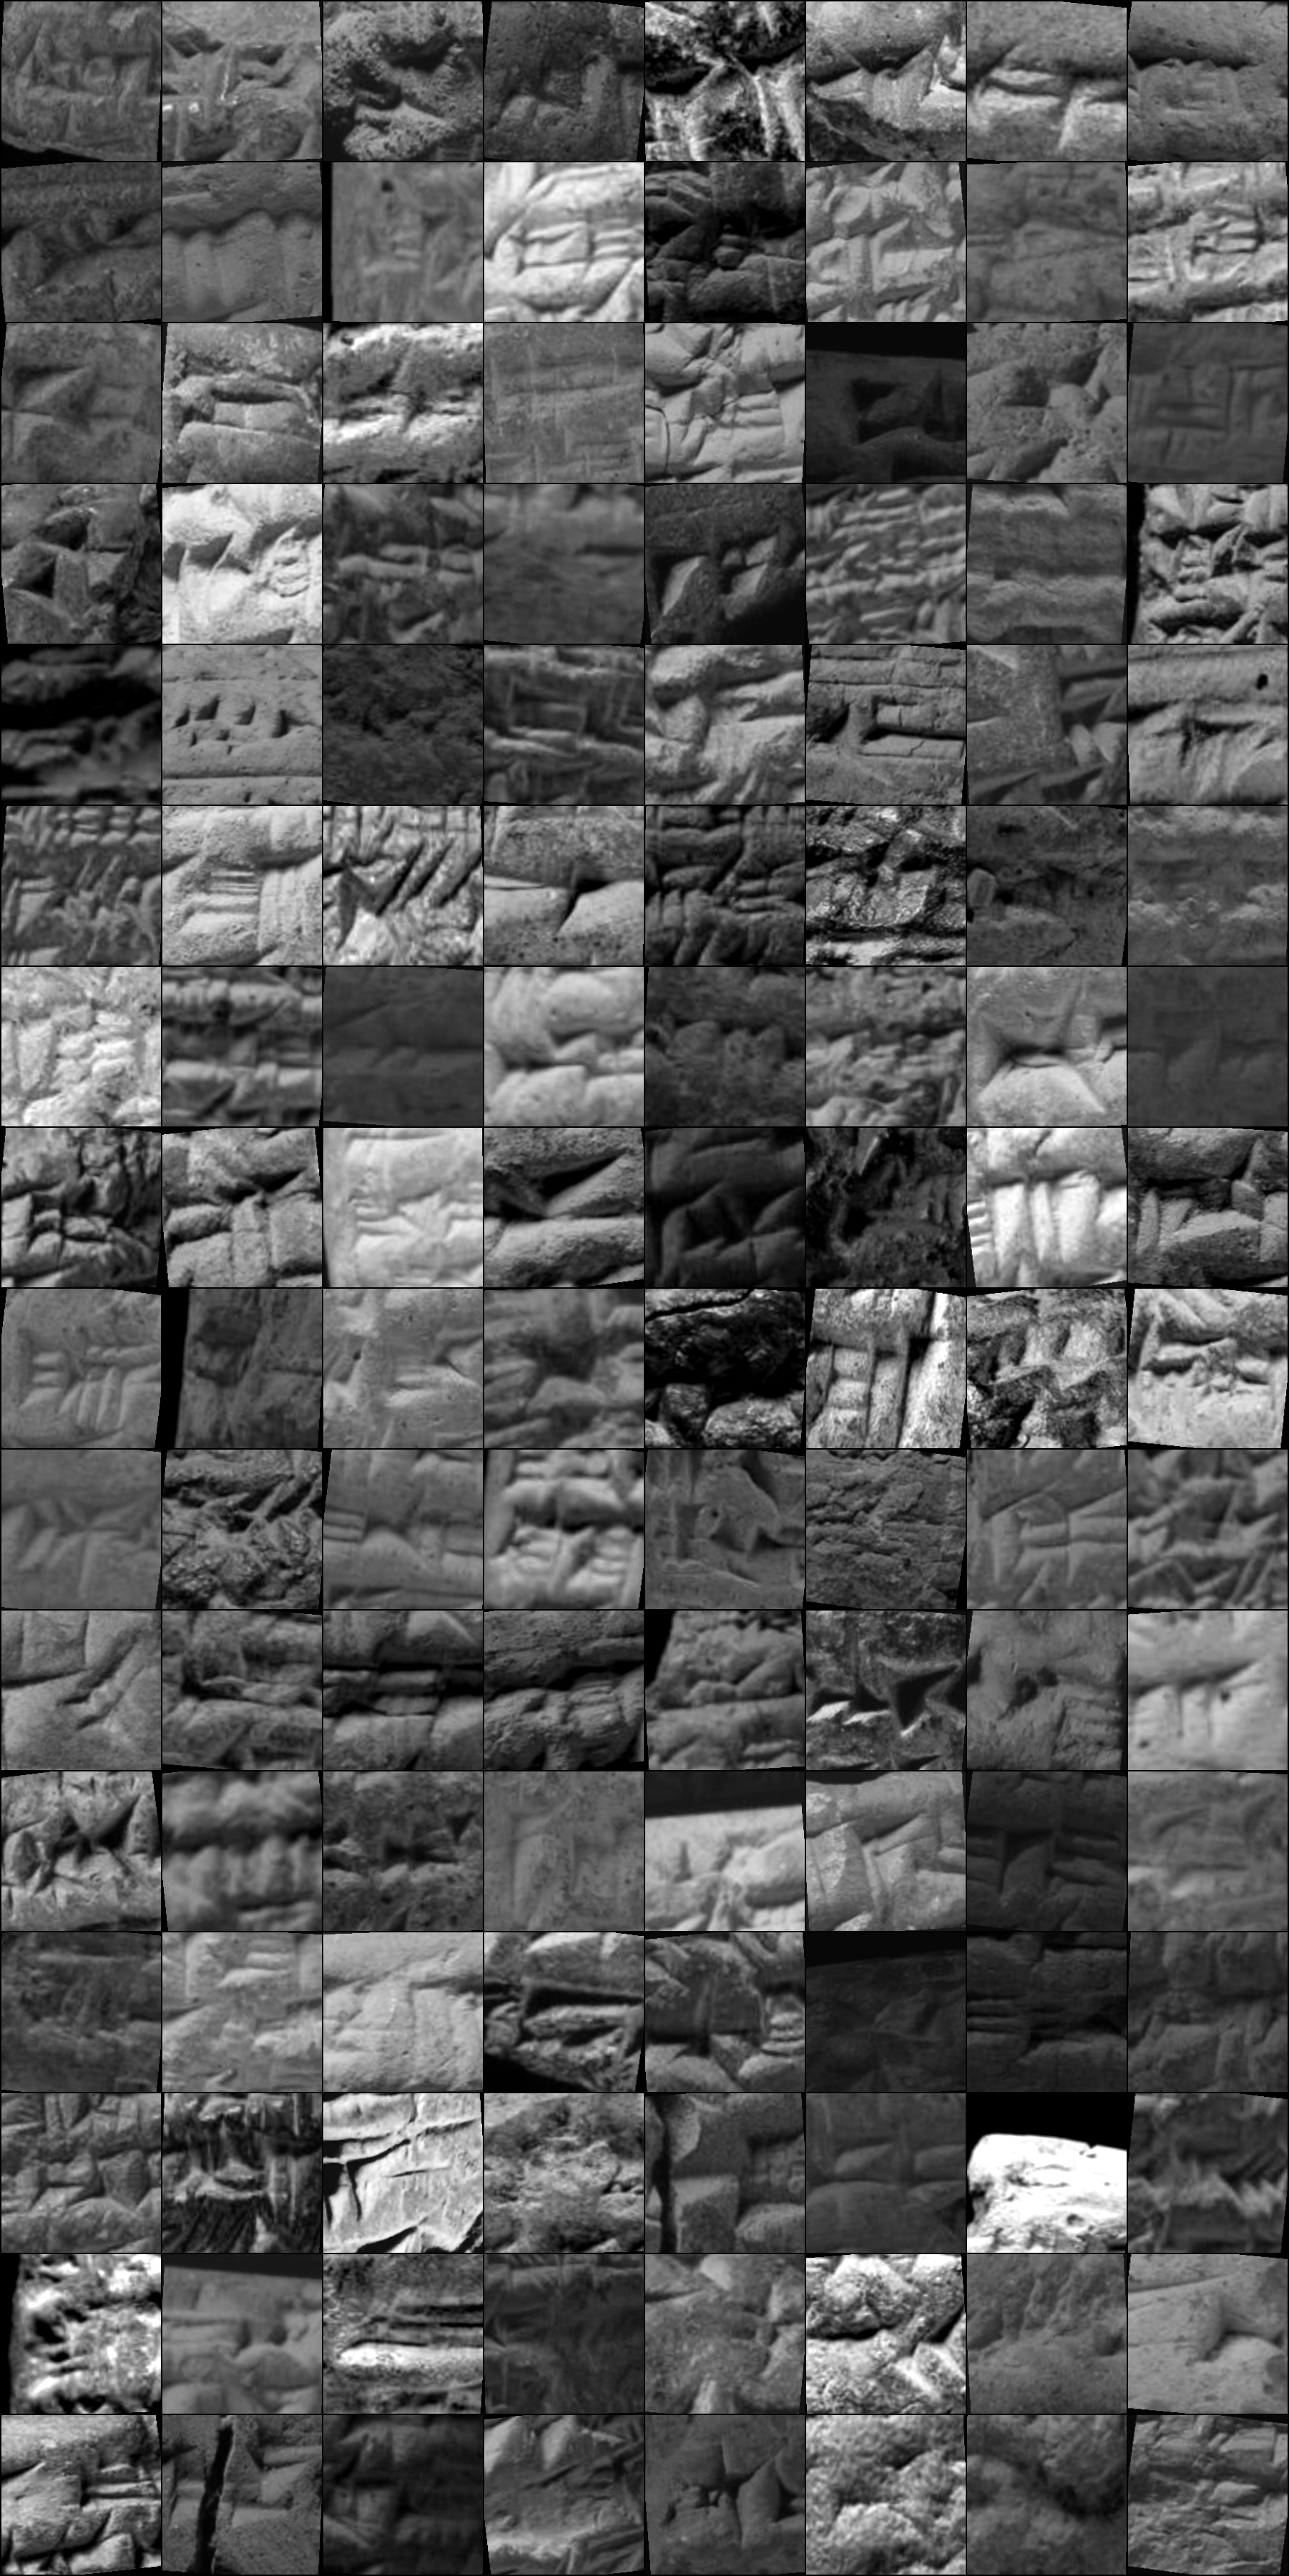

In [16]:
# Make a grid from batch [assume all images are ]
out = torchvision.utils.make_grid(inputs, pad_value=-gray_mean[0])
re_transform_rgb(out)

### Create Model

In [17]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [18]:
# choose model filename
weights_path = '{}results/weights/cuneiNet_basic_{}.pth'.format(relative_path, model_version)
assert not os.path.exists(weights_path), "Filename '{}' has already been claimed!".format(weights_path)

# load model definition
model_ft = MobileNetV2(input_size=224, width_mult=width_mult, n_class=num_classes, input_dim=num_c, 
                       arch_opt=arch_opt)

# deploy on device
model_ft = model_ft.to(device)

# print model
print(model_ft)

/home/tobias/.virtualenvs/pytorch/local/lib/python2.7/site-packages/torch/cuda/__init__.py:117: UserWarning: 
    Found GPU1 GeForce GTX 770 which is of cuda capability 3.0.
    PyTorch no longer supports this GPU because it is too old.
    
  warnings.warn(old_gpu_warn % (d, name, major, capability[1]))


MobileNetV2(
  (classifier): Sequential(
    (0): Dropout(p=0.5)
    (1): Linear(in_features=512, out_features=240, bias=True)
  )
  (features): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 20, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace)
    )
    (1): MobileBlock(
      (mobile_block): Sequential(
        (0): InvertedResidual(
          (conv): Sequential(
            (0): Conv2d(20, 20, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace)
            (3): Conv2d(20, 20, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=20, bias=False)
            (4): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (5): ReLU6(inplace)
            (6): Conv2d(20, 10, kernel_size=(1, 1),

### Config Trainer

In [19]:
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.08, momentum=0.9, weight_decay=0.0005, nesterov=True)  # 0.1
#optimizer_ft = torch.optim.Adam(model_ft.parameters(), lr=0.001, weight_decay=0.0005)

# Decay LR by a factor of 0.97
# exp_lr_scheduler = lr_scheduler.ExponentialLR(optimizer_ft, gamma=0.97)
lr_scheduler_ft = lr_scheduler.MultiStepLR(optimizer_ft, milestones=lr_milestones, gamma=0.1)

# init logger
#writer = SummaryWriter(comment='_{}'.format(weights_path.split('/')[1].split('.')[0]))
if version_remark == '':
    comment_str = '_{}'.format(model_version)
else:
    comment_str = '_{}_{}'.format(model_version, version_remark)
writer = get_tensorboard_writer(logs_folder='{}results/run_logs/classifier'.format(relative_path), comment=comment_str)


# writer.add_graph(model_ft, res)
writer.add_image('train/sample_input', out, 0) # depends on re_transform_rgb(out.clone()) being called once
writer.add_text('model/definition', model_ft.__str__(), 0)

In [20]:
print('num_params:', sum([param.nelement() for param in model_ft.parameters()]))

('num_params:', 717574)


### Train Model

In [21]:
# run
model_ft = train_model(model_ft, criterion, optimizer_ft, lr_scheduler_ft, 
                       writer, dataloaders, dataset_sizes, device, num_epochs=num_epochs, test_every=5)

# Save only the model parameters
torch.save(model_ft.state_dict(), weights_path)

  0%|          | 0/111 [00:00<?, ?it/s]

Epoch 0/110
----------
train Loss: 0.0307 Acc: 0.1534
train Number correct: 15816 


  1%|          | 1/111 [02:36<4:47:47, 156.98s/it]

dev Loss: 0.2274 Acc: 0.2568
dev Number correct: 890 
Epoch 1/110
----------


  2%|▏         | 2/111 [05:08<4:40:21, 154.33s/it]

train Loss: 0.0208 Acc: 0.3807
train Number correct: 39246 
Epoch 2/110
----------


KeyboardInterrupt: 

### Visualizations

In [ ]:
visualize_model(model_ft, dataloaders['dev'], re_transform, device)

In [ ]:
if False:
    feature_model = model_ft.features
    #feature_model = model_ft.model

    f_tensor, l_tensor, i_tensor = prepare_embedding(feature_model, dataloaders['dev'], re_transform, device)
    writer.add_embedding(f_tensor, metadata=l_tensor, label_img=i_tensor)

In [ ]:
# finish
writer.close()